In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from GaussianCopulaImp.gaussian_copula import GaussianCopula
from GaussianCopulaImp.low_rank_gaussian_copula import LowRankGaussianCopula
from GaussianCopulaImp.helper_data_generation import generate_sigma, generate_mixed_from_gc, generate_LRGC
from GaussianCopulaImp.helper_evaluation import get_rmse, get_mae, error_by_reliability
from GaussianCopulaImp.helper_mask import mask

## Confidence interval under full rank Gaussian copula model

We use a 2000*15 dimensional dataset generated from the Gaussian copula model whose marginals are exponential distribution with rate parameter 1/3. The coverage results are robust to different marginal distribution specification.

In [3]:
seed = 101
var_types = {'cont':list(range(15)), 'ord':[], 'bin':[]}
n = 2000

In [4]:
sigma = generate_sigma(seed, p=sum([len(value) for value in var_types.values()]))
X = generate_mixed_from_gc(sigma=sigma, n=n, seed=seed, var_types=var_types)
X_masked = mask(X, mask_fraction=0.4, seed=seed)

In [5]:
model = GaussianCopula(verbose=1)

In [6]:
Ximp = model.fit_transform(X=X_masked)

Iteration 1: copula correlation update ratio 0.125, likelihood -3.395
Copula correlation change ratio:  0.1247
Iteration 2: copula correlation update ratio 0.068, likelihood -3.170
Copula correlation change ratio:  0.068
Iteration 3: copula correlation update ratio 0.038, likelihood -3.030
Copula correlation change ratio:  0.0383
Iteration 4: copula correlation update ratio 0.023, likelihood -2.938
Copula correlation change ratio:  0.0233
Iteration 5: copula correlation update ratio 0.015, likelihood -2.872
Copula correlation change ratio:  0.0153
Iteration 6: copula correlation update ratio 0.011, likelihood -2.824
Copula correlation change ratio:  0.0107
Iteration 7: copula correlation update ratio 0.008, likelihood -2.788
Copula correlation change ratio:  0.0079
Convergence achieved at iteration 7


In [7]:
get_rmse(x_imp = Ximp, x_true = X, x_obs = X_masked, relative = True)

0.5222093777725176

In [8]:
cover_rate = {}
for alpha in [0.85, 0.9, 0.95]:
    out_confidence_interval = model.get_imputed_confidence_interval(alpha = alpha)
    missing_loc = np.isnan(X_masked)
    lower, upper = out_confidence_interval['lower'], out_confidence_interval['upper']
    cover = (lower[missing_loc] < X[missing_loc]) & (upper[missing_loc] > X[missing_loc])
    cover_rate[alpha] = np.array(cover).mean()

The returned confidence intervals are slightly higher than the specified coverage rate

In [9]:
for key, val in cover_rate.items():
    print(f'The actual coverage rate is {val:.3f} with specified coverage rate {key:.3f}')

The actual coverage rate is 0.881 with specified coverage rate 0.850
The actual coverage rate is 0.922 with specified coverage rate 0.900
The actual coverage rate is 0.965 with specified coverage rate 0.950


## Reliability for continuous data under full rank Gaussian copula model

In [10]:
reliability = model.get_reliability(Ximp = Ximp)

In [11]:
nrmse_by_reliability = error_by_reliability('NRMSE', reliability, 
                                            xtrue=X, ximp=Ximp)

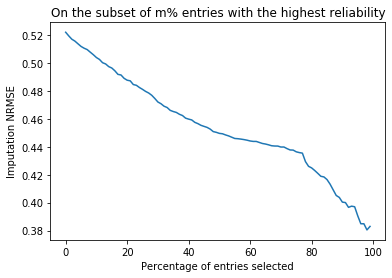

In [12]:
fig,ax = plt.subplots()
ax.plot(nrmse_by_reliability)
_ = ax.set_ylabel('Imputation NRMSE')
_ = ax.set_xlabel('Percentage of entries selected')
_ = ax.set_title('On the subset of m% entries with the highest reliability')

## Reliability for ordinal data under full rank Gaussian copula model

### Ordinal variables with ratings 1-5

In [13]:
var_types = {'cont':[], 'ord':list(range(15)), 'bin':[]}

In [14]:
sigma = generate_sigma(seed, p=sum([len(value) for value in var_types.values()]))
X = generate_mixed_from_gc(sigma=sigma, n=n, seed=seed, var_types=var_types)
X_masked = mask(X, mask_fraction=0.4, seed=seed)

In [15]:
model = GaussianCopula(verbose=1)
Ximp = model.fit_transform(X=X_masked)

Iteration 1: copula correlation update ratio 0.126, likelihood -3.243
Copula correlation change ratio:  0.1262
Iteration 2: copula correlation update ratio 0.081, likelihood -3.019
Copula correlation change ratio:  0.0814
Iteration 3: copula correlation update ratio 0.052, likelihood -2.843
Copula correlation change ratio:  0.0519
Iteration 4: copula correlation update ratio 0.034, likelihood -2.709
Copula correlation change ratio:  0.0338
Iteration 5: copula correlation update ratio 0.023, likelihood -2.606
Copula correlation change ratio:  0.0229
Iteration 6: copula correlation update ratio 0.016, likelihood -2.528
Copula correlation change ratio:  0.0161
Iteration 7: copula correlation update ratio 0.012, likelihood -2.466
Copula correlation change ratio:  0.0117
Iteration 8: copula correlation update ratio 0.009, likelihood -2.418
Copula correlation change ratio:  0.0088
Convergence achieved at iteration 8


In [16]:
get_mae(x_imp = Ximp, x_true = X, x_obs = X_masked)

0.42691666666666667

The default setting of evaluation computes the imputation error in the grid of 100 points. It could happen sometimes the entries with very high reliability (a few top percentiles) are in fact, as shown below.

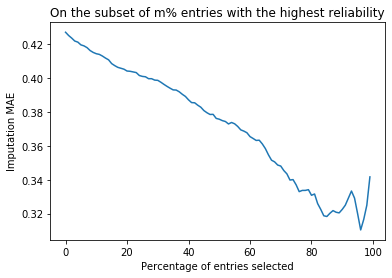

In [17]:
reliability = model.get_reliability()

mae_by_reliability = error_by_reliability('MAE', reliability, 
                                          xtrue=X, ximp=Ximp)

fig,ax = plt.subplots()
ax.plot(mae_by_reliability)
_ = ax.set_ylabel('Imputation MAE')
_ = ax.set_xlabel('Percentage of entries selected')
_ = ax.set_title('On the subset of m% entries with the highest reliability')

If we sample smaller number of points in the grid such that each point is evaluated with more data points, the curve looks good again.

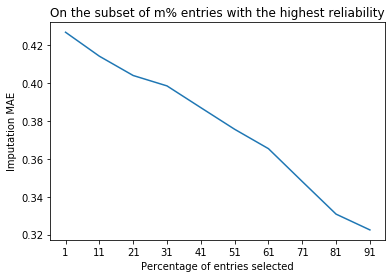

In [18]:
mae_by_reliability = error_by_reliability('MAE', reliability, 
                                          xtrue=X, ximp=Ximp, num=10)

fig,ax = plt.subplots()
ax.plot(mae_by_reliability)
_ = ax.set_ylabel('Imputation MAE')
_ = ax.set_xlabel('Percentage of entries selected')
_ = ax.set_title('On the subset of m% entries with the highest reliability')
_ = ax.set_xticks(list(range(10)))
_ = ax.set_xticklabels([str(x+1) for x in range(0, 100, 10)])

### Binary variables

In [19]:
var_types = {'cont':[], 'ord':[], 'bin':list(range(15))}

sigma = generate_sigma(seed, p=sum([len(value) for value in var_types.values()]))
X = generate_mixed_from_gc(sigma=sigma, n=n, seed=seed, var_types=var_types)
X_masked = mask(X, mask_fraction=0.4, seed=seed)

In [20]:
model = GaussianCopula(verbose=1)
Ximp = model.fit_transform(X=X_masked)

Iteration 1: copula correlation update ratio 0.096, likelihood -2.671
Copula correlation change ratio:  0.0956
Iteration 2: copula correlation update ratio 0.075, likelihood -2.547
Copula correlation change ratio:  0.0747
Iteration 3: copula correlation update ratio 0.056, likelihood -2.437
Copula correlation change ratio:  0.0558
Iteration 4: copula correlation update ratio 0.041, likelihood -2.341
Copula correlation change ratio:  0.0407
Iteration 5: copula correlation update ratio 0.029, likelihood -2.262
Copula correlation change ratio:  0.0293
Iteration 6: copula correlation update ratio 0.021, likelihood -2.199
Copula correlation change ratio:  0.021
Iteration 7: copula correlation update ratio 0.015, likelihood -2.150
Copula correlation change ratio:  0.0151
Iteration 8: copula correlation update ratio 0.011, likelihood -2.113
Copula correlation change ratio:  0.0109
Iteration 9: copula correlation update ratio 0.008, likelihood -2.084
Copula correlation change ratio:  0.0079
Co

In [21]:
get_mae(x_imp = Ximp, x_true = X, x_obs = X_masked)

0.3139166666666667

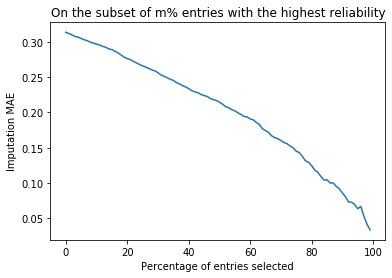

In [22]:
reliability = model.get_reliability()

mae_by_reliability = error_by_reliability('MAE', reliability, 
                                          xtrue=X, ximp=Ximp)

fig,ax = plt.subplots()
ax.plot(mae_by_reliability)
_ = ax.set_ylabel('Imputation MAE')
_ = ax.set_xlabel('Percentage of entries selected')
_ = ax.set_title('On the subset of m% entries with the highest reliability')

## Confidence interval under low rank Gaussian copula model

We use a 500*200 dimensional dataset generated from the low rank Gaussian copula model whose marginals are cubic of standard normals. The coverage results are robust to different marginal distribution specification.

In [23]:
seed = 101
var_types = {'cont':list(range(200)), 'ord':[], 'bin':[]}

In [24]:
X, Wtrue = generate_LRGC(var_types=var_types, 
                             rank=10, sigma=0.1, 
                             n=500, cont_transform=lambda x:x**3,
                             seed=seed)

X_masked = mask(X, mask_fraction = 0.4, seed=seed)

In [25]:
model = LowRankGaussianCopula(rank=10, verbose=1)
Ximp = model.fit_transform(X=X_masked)

Ater initialization, W has shape (200, 10) and sigma is 0.13660508507418753
Interation 1: noise ratio estimate 0.105, copula parameter update ratio 0.064, likelihood 171.248
Interation 2: noise ratio estimate 0.100, copula parameter update ratio 0.006, likelihood 196.867
Interation 3: noise ratio estimate 0.099, copula parameter update ratio 0.003, likelihood 201.249
early stop because changed likelihood below 1%


In [26]:
get_rmse(x_imp = Ximp, x_true = X, x_obs = X_masked, relative = True)

0.5177723167413107

In [27]:
cover_rate = {}
for alpha in [0.85, 0.9, 0.95]:
    out_confidence_interval = model.get_imputed_confidence_interval(alpha = alpha)
    missing_loc = np.isnan(X_masked)
    lower, upper = out_confidence_interval['lower'], out_confidence_interval['upper']
    cover = (lower[missing_loc] < X[missing_loc]) & (upper[missing_loc] > X[missing_loc])
    cover_rate[alpha] = np.array(cover).mean()

The returned confidence intervals are slightly lower than the specified coverage rate

In [28]:
for key, val in cover_rate.items():
    print(f'The actual coverage rate is {val:.3f} with specified coverage rate {key:.3f}')

The actual coverage rate is 0.824 with specified coverage rate 0.850
The actual coverage rate is 0.875 with specified coverage rate 0.900
The actual coverage rate is 0.930 with specified coverage rate 0.950


## Reliability for continuous data under low rank Gaussian copula model

In [29]:
reliability = model.get_reliability(Ximp = Ximp)
nrmse_by_reliability = error_by_reliability('NRMSE', reliability, 
                                            xtrue=X, ximp=Ximp)

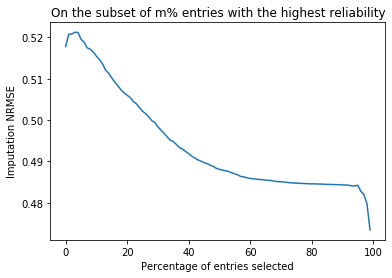

In [30]:
fig,ax = plt.subplots()
ax.plot(nrmse_by_reliability)
_ = ax.set_ylabel('Imputation NRMSE')
_ = ax.set_xlabel('Percentage of entries selected')
_ = ax.set_title('On the subset of m% entries with the highest reliability')

## Reliability for ordinal data under low rank Gaussian copula model

### Ordinal variables with ratings 1-5

In [31]:
var_types = {'cont':[], 'ord':list(range(200)), 'bin':[]}

X, Wtrue = generate_LRGC(var_types=var_types, 
                             rank=10, sigma=0.1, 
                             n=500, cont_transform=lambda x:x**3,
                             seed=seed)

X_masked = mask(X, mask_fraction = 0.4, seed=seed)

In [32]:
model = LowRankGaussianCopula(rank=10, verbose=1)
Ximp = model.fit_transform(X=X_masked)

Ater initialization, W has shape (200, 10) and sigma is 0.2116882602963095
Interation 1: noise ratio estimate 0.157, copula parameter update ratio 0.068, likelihood 125.789
Interation 2: noise ratio estimate 0.134, copula parameter update ratio 0.025, likelihood 159.248
Interation 3: noise ratio estimate 0.122, copula parameter update ratio 0.012, likelihood 175.171
Interation 4: noise ratio estimate 0.115, copula parameter update ratio 0.007, likelihood 184.448
Interation 5: noise ratio estimate 0.110, copula parameter update ratio 0.004, likelihood 190.432
Interation 6: noise ratio estimate 0.107, copula parameter update ratio 0.003, likelihood 194.539
Interation 7: noise ratio estimate 0.105, copula parameter update ratio 0.002, likelihood 197.473
Interation 8: noise ratio estimate 0.103, copula parameter update ratio 0.002, likelihood 199.627
early stop because changed likelihood below 1%


In [33]:
get_mae(x_imp = Ximp, x_true = X, x_obs = X_masked)

0.23805

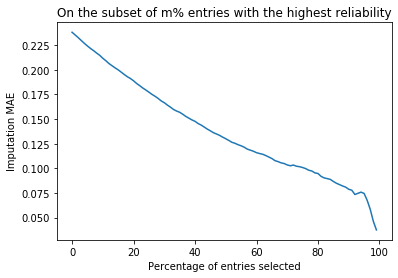

In [34]:
reliability = model.get_reliability()

mae_by_reliability = error_by_reliability('MAE', reliability, 
                                          xtrue=X, ximp=Ximp)

fig,ax = plt.subplots()
ax.plot(mae_by_reliability)
_ = ax.set_ylabel('Imputation MAE')
_ = ax.set_xlabel('Percentage of entries selected')
_ = ax.set_title('On the subset of m% entries with the highest reliability')

### Binary variables

In [35]:
var_types = {'cont':[], 'ord':[], 'bin':list(range(200))}

X, Wtrue = generate_LRGC(var_types=var_types, 
                             rank=10, sigma=0.1, 
                             n=500, cont_transform=lambda x:x**3,
                             seed=seed)

X_masked = mask(X, mask_fraction = 0.4, seed=seed)

In [ ]:
model = LowRankGaussianCopula(rank=10, verbose=1)
Ximp = model.fit_transform(X=X_masked)

Ater initialization, W has shape (200, 10) and sigma is 0.30613083032644917
Interation 1: noise ratio estimate 0.225, copula parameter update ratio 0.103, likelihood 94.495
Interation 2: noise ratio estimate 0.185, copula parameter update ratio 0.042, likelihood 126.193
Interation 3: noise ratio estimate 0.163, copula parameter update ratio 0.023, likelihood 146.153
Interation 4: noise ratio estimate 0.150, copula parameter update ratio 0.015, likelihood 158.343
Interation 5: noise ratio estimate 0.141, copula parameter update ratio 0.011, likelihood 166.714
Interation 6: noise ratio estimate 0.134, copula parameter update ratio 0.008, likelihood 172.835
Interation 7: noise ratio estimate 0.129, copula parameter update ratio 0.006, likelihood 177.482
Interation 8: noise ratio estimate 0.125, copula parameter update ratio 0.005, likelihood 181.096
Interation 9: noise ratio estimate 0.123, copula parameter update ratio 0.004, likelihood 183.949
Interation 10: noise ratio estimate 0.120, 

In [ ]:
reliability = model.get_reliability()

mae_by_reliability = error_by_reliability('MAE', reliability, 
                                          xtrue=X, ximp=Ximp)

fig,ax = plt.subplots()
ax.plot(mae_by_reliability)
_ = ax.set_ylabel('Imputation MAE')
_ = ax.set_xlabel('Percentage of entries selected')
_ = ax.set_title('On the subset of m% entries with the highest reliability')